In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
%matplotlib inline

from data_builder import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pickle
from model_builder import get_models

In [37]:
parser = argparse.ArgumentParser()
parser.add_argument("-n_test_traj", '--ntesttraj', type=int, default=25)
parser.add_argument('-dt', '--dt', type=float, default=0.05)
parser.add_argument('-tmax', '--tmax', type=float, default=6.05)
parser.add_argument('-dname', '--dname', type=str, default='mass_spring')
parser.add_argument('-noise_std', '--noise', type=float, default=0)
parser.add_argument('-type','--type',type=int,default=1)
args = parser.parse_args([])
n_test_traj = args.ntesttraj
T_max = args.tmax
T_max_t = args.tmax
dt = args.dt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
type_vec = args.type
num_samples_per_traj = int(np.ceil((T_max / dt))) - 1

if args.noise != 0:
    noisy = True
else:
    noisy = False

dataset_name = args.dname

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=10,type=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}

main_pred = {'baseline':[],'HNN':[],'TDHNN':[],'TDHNN1':[],'TDHNN2':[],'TDHNN3':[]}


def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( t, requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)

def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
#                 energy_.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = integrate_model(model,[0,T_max_t],qinit.detach().numpy().ravel(),t_eval=np.arange(0,T_max_t,dt)).y
#             preds = []
#             for i in range(len(q_next)):
#                 next_step_pred = model.next_step(qinit,tevals[i])
#                 preds.append(next_step_pred)
#                 qinit = next_step_pred

#             preds = torch.cat(preds).detach().numpy()
#             q_next = q_next.detach().numpy()

            main_pred[model_name].append(((preds.T)[:-1],q.detach().numpy()))




In [48]:
# model_ft = HNN(2, 200, 1, 0.01)
model_dct = get_models(dt, type=None, hidden_dim=200)
for model_name in model_dct.keys():
    model_type = torch.load(f'mass_spring/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

In [49]:
def hamiltonian_fn(coords):
    q, p = coords[:,0],coords[:,1]
    K = (p ** 2) / 2 
    U = (q ** 2) / 2  # spring hamiltonian (linear oscillator)
    return K,U

In [50]:
def hamiltonian_fn2(coords):
    q, p = coords[:,0],coords[:,1]
    K = (p ** 2) / 2 
    U = (q ** 2) / 2  # spring hamiltonian (linear oscillator)
    return K+U

In [51]:
avg_perf = {}
for model in model_dct.keys():
    vals = main_pred[model]
    err=0
    ener=0
    for i in range(len(vals)):
        pred = vals[i][0]
        true = vals[i][1]
        err += np.mean(np.square(pred-true))
        ener += np.mean(np.square(hamiltonian_fn2(pred)-hamiltonian_fn2(true)))
    err = err/len(vals)
    ener = ener/len(vals)
    print(f'{model}:{err}')
    print(f'{model}:{ener}')
    avg_perf[model] = err

HNN:1.0996363912125783e-05
HNN:9.640563115968603e-08
TDHNN2:1.3479711600252045e-05
TDHNN2:2.3866006331475624e-07


In [52]:
avg_perf.values

<function dict.values>

In [53]:
list(avg_perf.keys())

['HNN', 'TDHNN2']

<BarContainer object of 2 artists>

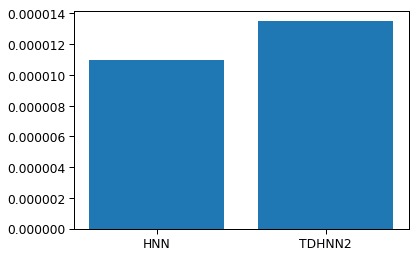

In [54]:
plt.bar(list(avg_perf.keys()),list(avg_perf.values()))

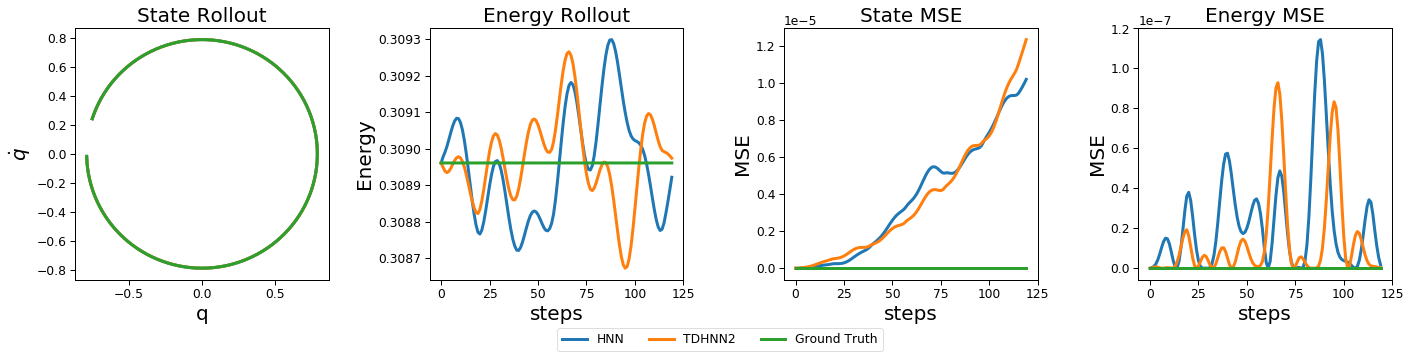

In [55]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_dct.keys())
fig,axs = plt.subplots(1,4,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-5][0]#main_pred_coll[dex]
    true_batch = main_pred[name][-5][1]
                    
    K_pred,U_pred = hamiltonian_fn(yhat)
    K_true,U_true = hamiltonian_fn(true_batch)
    ham_pred = K_pred + U_pred
    ham_true = K_true + U_true
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('steps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('steps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('mass_spring_long.pdf',dpi=2400,bbox_inches='tight')


In [56]:
for name, param in model_type.named_parameters():
    if param.requires_grad:
        print (name, param.data)

W tensor([[0.1356]])
mlp1.weight tensor([[-0.0258, -0.1357],
        [-0.0256, -0.0586],
        [ 0.0528, -0.0772],
        [-0.2087,  0.0581],
        [ 0.0011,  0.0496],
        [ 0.0283, -0.1016],
        [-0.0937,  0.0637],
        [ 0.0675, -0.0174],
        [-0.0094, -0.0308],
        [ 0.1895,  0.0724],
        [ 0.0071,  0.0414],
        [ 0.0068,  0.0871],
        [ 0.0635, -0.0990],
        [-0.2232,  0.1377],
        [ 0.0740,  0.0414],
        [ 0.0880, -0.0863],
        [ 0.0953, -0.0260],
        [ 0.1111,  0.1030],
        [-0.0026, -0.0527],
        [ 0.1460, -0.0572],
        [ 0.0822, -0.0405],
        [ 0.0688, -0.0401],
        [ 0.0552, -0.2209],
        [-0.0173, -0.0376],
        [-0.0513, -0.1587],
        [ 0.0821, -0.0500],
        [-0.0012, -0.0210],
        [ 0.0552, -0.0435],
        [ 0.0551,  0.0602],
        [ 0.0105,  0.0631],
        [-0.1213,  0.0917],
        [ 0.0614, -0.0553],
        [ 0.0127,  0.1444],
        [-0.0212, -0.0747],
        [-0.131

In [58]:
torch.relu(torch.sigmoid(torch.tensor(0.135))-0.5)

tensor(0.0337)

In [59]:
(model_type.get_weight())

tensor([[0.0338]], grad_fn=<ReluBackward0>)

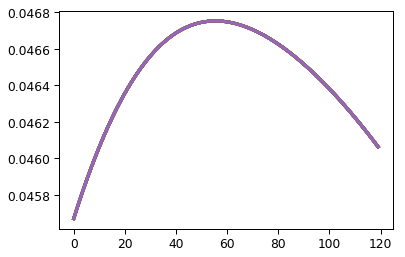

In [61]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    f = model_type.get_F(tevals.reshape(-1,1))
    plt.plot(-0.03381*f.detach().numpy())

In [21]:
int(np.ceil(10.05/0.05))

201

In [17]:
torch.round(torch.tensor(0.6))

tensor(1.)